In [85]:
#!g1.1
import os

PATH_TO_DATASET_ARCHIVE = "Vex No-Ero.zip"
# target dir to unzip imgs from archive
PATH_TO_DATASET_IMGS = 'vex_ds'
PATH_TO_DATASET_MASKS = 'vex_masks_ds'
PATH_TO_ANNOTATIONS = 'updated_vex_anns.json'

COMMON_PATH_TO_MODELS = os.path.join('saved_models_vex_segm')
PATH_TO_MODEL = {
    'Simple_FCN': {
        'path': os.path.join(COMMON_PATH_TO_MODELS, 'Simple_FCN'),
        'is_saved': True
    },
    'Enc_Dec_FCN': {
        'path': os.path.join(COMMON_PATH_TO_MODELS, 'Enc_Dec_FCN'),
        'is_saved': True,
    },
    'Trained_Unet': {
        'path': os.path.join(COMMON_PATH_TO_MODELS, 'Trained_Unet'),
        'is_saved': True,
    },
    'My_Unet': {
        'path': os.path.join(COMMON_PATH_TO_MODELS, 'My_Unet'),
        'is_saved': True
    },
    'My_Opt_Unet': {
        'path': os.path.join(COMMON_PATH_TO_MODELS, 'My_Opt_Unet'),
        'is_saved': False
    }
}

INFO:tensorflow:Assets written to: ram://e545ca1d-0559-4ceb-8ccd-d8d9f4c25984/assets


INFO:tensorflow:Assets written to: ram://e545ca1d-0559-4ceb-8ccd-d8d9f4c25984/assets


INFO:tensorflow:Assets written to: ram://5ff25d49-1a6c-4706-914c-929f8a2b46b9/assets


INFO:tensorflow:Assets written to: ram://5ff25d49-1a6c-4706-914c-929f8a2b46b9/assets


INFO:tensorflow:Assets written to: ram://c30deefb-cae7-416a-9fcd-b7643cbcc184/assets


INFO:tensorflow:Assets written to: ram://c30deefb-cae7-416a-9fcd-b7643cbcc184/assets


In [12]:
#!g1.1
EPOCHS = 50
BATCH_SIZE = 8
# Upd, модель падает по памяте на батч сайзе больше 1го, если изображение 2к на 2к. 
# С 512х512 - тянет 8 картинок в батче, мб даже больше.
BG_CAT_ID = 2 # Id категории фона

In [13]:
#!g1.1
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

2022-09-06 10:26:07.998273: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## План на тетрадку
Мне полезно(и интересно) будет наблюдать за развитием моей будущей FCN модели.
1. Начну с простой FCN с ресайзом "бутылоч. горлышка".
2. Затем реализую полноценную FCN с энкодером-декодером. Делаю симметричные энкодер\декодер.
Заранее делаю сеть глубокой и приводимой к U-net архитектуре, в т.ч. и по глубине о:
Сначала с простыми Unsampling2D или мб даже ресайзом(с билленарным преобразованием).
3. Затем пробую использовать приемы вроде:
	Разные Unpooling слои: stride(разреженный) unpooling, ближ. сосед, max unpooling
	Свертки со страйдом вместо обычного пулинга и транспорнированные свертки(Upconv слои)
	
	Поэкспериментировать в разных конфигурациях, вполне может оказаться unconv будет чуть хуже чем простой анпулинг ближ.соседа + свертка.
4. Добавляю скип-коннекшены и привожу к модели U-net
5. Добавляю ASPP блок.

**UPD. Дополнение задания**
Нужно еще попробовать разные варианты реализации(что лучше работает):
- бинарная классификация с разделением по каналам маски ground-truth
- спарс классификация с общей маской на входе и неск.(по количеству классов) маской на выходе.
- бинарная\спарс классификация ИЗ ЛОГИТОВ(сейчас я сразу вероятности возвращаю)

Чтобы гугл-колаб не душил - сохраняю модели в ходе обучения, ибо обучаться оно будет долго скорее всего.

Ну и реализовывать модель в виде класса, для практики.
______
#### Назначение модели
 
Изображения - официальные и фан-арты, в т.ч. и хентаё.
_______
#### Про модельку "как есть"
Назначение модели - распознавание персонажей ЛОЛ на изображении с семантической сегментацией(без разделения на объекты). 
И полезно и интересно.
Я бы даже сказал - трипл интересно\полезно - задача распознавания и сегментации персонажей на артах, в т.ч. и эро артах.
Применений куча:  
1) Насколько арт отражает героя по которому он нарисован(не просто рандомная тня, которую можно узнать только по надписи)  
2) Авторазметка\автоклассификация персонажей на картинках после обучения  
3) Сегментацию можно юзать для какой то коллажной деятельности(не мне, так другим полезно будет).

Т.е. вот такой датасет собираю. Сначала только с джоя. Скачиваю все картинки, выберу только одного героя.

Upd. Выбрал Векс, довольно выразительный персонаж.

## Подготовка данных

### Распаковка архива с датасетом изображений

In [14]:
#!g1.1
!unzip -o "Vex No-Ero.zip" -d "vex_ds"

Archive:  Vex No-Ero.zip
  inflating: vex_ds/101_League-of-Legends-фэндомы-Fizz-Vex-LoL-6929445.jpeg  
  inflating: vex_ds/102_League-of-Legends-фэндомы-Fizz-Vex-LoL-6929446.jpeg  
  inflating: vex_ds/109_League-of-Legends-фэндомы-Vex-LoL-Viego-6931146.jpeg  
  inflating: vex_ds/110_League-of-Legends-фэндомы-Vex-LoL-Viego-6931147.jpeg  
  inflating: vex_ds/111_League-of-Legends-фэндомы-Vex-LoL-Viego-6931148.jpeg  
  inflating: vex_ds/115_League-of-Legends-фэндомы-Lulu-Vex-LoL-6934560.jpeg  
  inflating: vex_ds/116_League-of-Legends-фэндомы-Lulu-Vex-LoL-6934561.jpeg  
  inflating: vex_ds/117_League-of-Legends-фэндомы-Lulu-Vex-LoL-6934562.jpeg  
  inflating: vex_ds/118_League-of-Legends-фэндомы-RAIZOSUN-Vex-LoL-6936470.jpeg  
  inflating: vex_ds/119_Vex-LoL-League-of-Legends-фэндомы-kinokodake365-6938426.jpeg  
  inflating: vex_ds/12_Vex-LoL-myanja-LoL-Ero-League-of-Legends-6810359.png  
  inflating: vex_ds/120_Vex-LoL-League-of-Legends-фэндомы-kinokodake365-6938427.jpeg  
  inflating: v

### Обзор данных аннотаций
Формат используется в данной работе - COCO JSON.

In [15]:
#!g1.1
import json

annotations = json.load(open(PATH_TO_ANNOTATIONS))

In [16]:
#!g1.1
annotations.keys()

dict_keys(['info', 'images', 'annotations', 'categories'])

In [17]:
#!g1.1
annotations['info']

{'description': 'my-project-name'}

In [18]:
#!g1.1
annotations['images'][:1]

[{'id': 1,
  'width': 1507,
  'height': 1015,
  'file_name': '101_League-of-Legends-фэндомы-Fizz-Vex-LoL-6929445.jpeg'}]

Пример одного изображения с разными категориями(3 объекта аннотации):

In [19]:
#!g1.1
annotations['annotations'][3:6]

[{'id': 3,
  'iscrowd': 0,
  'image_id': 4,
  'category_id': 1,
  'segmentation': [[1155.9129852283038,
    881.2124525716689,
    1167.5357637988056,
    892.0050326728493,
    1176.667946961343,
    902.7976127740297,
    1170.0263592067704,
    911.0995974672454,
    1179.9887408386294,
    920.2317806297827,
    1175.8377484920215,
    931.8545592002847,
    1190.7813209398098,
    947.6283301173946,
    1201.3333129882812,
    950.78125,
    1212.3333129882812,
    948.78125,
    1213.3333129882812,
    935.78125,
    1195.3333129882812,
    921.78125,
    1207.3333129882812,
    904.78125,
    1199.3333129882812,
    900.78125,
    1210.3333129882812,
    886.78125,
    1204.3333129882812,
    881.78125,
    1205.3333129882812,
    855.78125,
    1213.3333129882812,
    842.78125,
    1203.3333129882812,
    827.78125,
    1195.3333129882812,
    826.78125,
    1191.3333129882812,
    813.78125,
    1229.3333129882812,
    832.78125,
    1241.3333129882812,
    822.78125,
    124

In [20]:
#!g1.1
annotations['categories']

[{'id': 1, 'name': 'Vex'},
 {'id': 2, 'name': 'Background'},
 {'id': 3, 'name': 'nose'},
 {'id': 4, 'name': 'leftEye'},
 {'id': 5, 'name': 'rightEye'},
 {'id': 6, 'name': 'leftEar'},
 {'id': 7, 'name': 'rightEar'},
 {'id': 8, 'name': 'leftShoulder'},
 {'id': 9, 'name': 'rightShoulder'},
 {'id': 10, 'name': 'leftElbow'},
 {'id': 11, 'name': 'rightElbow'},
 {'id': 12, 'name': 'leftWrist'},
 {'id': 13, 'name': 'rightWrist'},
 {'id': 14, 'name': 'leftHip'},
 {'id': 15, 'name': 'rightHip'},
 {'id': 16, 'name': 'leftKnee'},
 {'id': 17, 'name': 'rightKnee'},
 {'id': 18, 'name': 'leftAnkle'},
 {'id': 19, 'name': 'rightAnkle'}]

JSON:
- info - название проекта
- images - инфа о изображении: имя + ширина и высота
- annotations - собственно аннотации
  - segmentation - координаты полигона, список, где X,Y точки записаны последовательно, как \[X1,Y1,X2,Y2...\]
  - bbox - судя по всему прямоугольная область в которой поместился полигон.
  - area - площадь полигона
  - category_id - id объекта в полигоне. **Разные объекты на одном изображении - разные объекты в списке аннотации!**
  - image_id - id изображения для аннотации
- categories - собс-но категории объектов

### Попалось изображения с 4мя каналами
Не думал, что такие встречу вообще когда нибудь, но мне повезло попасть на такое в выборке из 30 размеченных картинок.

Из за лишнего канала - весь пайплайн стал раком.  
(Внешне при этом картинку с 3мя каналами от картинки с 4мя - не отличить х_х)
_______
Такое изображение в одном экземпляре, дальше, при создании датасета, я явно указываю, что у моих изображений только 3 канала может быть!


2022-09-06 10:26:52.119912: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-06 10:26:55.759495: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:222] Using CUDA malloc Async allocator for GPU: 0
2022-09-06 10:26:55.765188: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30989 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8c:00.0, compute capability: 7.0


(2471, 1755, 4)


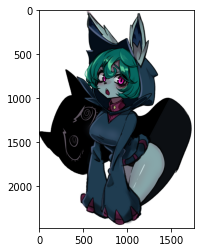

In [21]:
#!g1.1
# изображение "как есть", с 4мя каналами
wrong_img = tf.io.read_file('vex_ds/12_Vex-LoL-myanja-LoL-Ero-League-of-Legends-6810359.png')
wrong_img = tf.image.decode_jpeg(wrong_img)
print(wrong_img.shape)

plt.imshow(wrong_img)

(2471, 1755, 3)


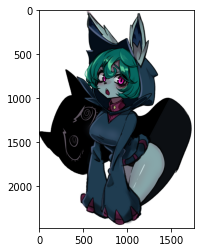

In [22]:
#!g1.1
# изображение, выведенное 3 мя каналами
wrong_img = tf.io.read_file('vex_ds/12_Vex-LoL-myanja-LoL-Ero-League-of-Legends-6810359.png')
wrong_img = tf.image.decode_jpeg(wrong_img, channels=3)
print(wrong_img.shape)

plt.imshow(wrong_img)

### Создаю свою первую маску(работа с PIL)

In [23]:
#!g1.1
from PIL import Image, ImageDraw
from PIL import ImagePath 

Картинку с нужным id найти довольно просто - index - 1.  
**Если очень хочется - можно превратить в объект объектов, где ключ - id элемента.**(Что я дальше и сделал)

In [24]:
#!g1.1
annotations['images'][9]

{'id': 10,
 'width': 1029,
 'height': 2057,
 'file_name': '119_Vex-LoL-League-of-Legends-фэндомы-kinokodake365-6938426.jpeg'}

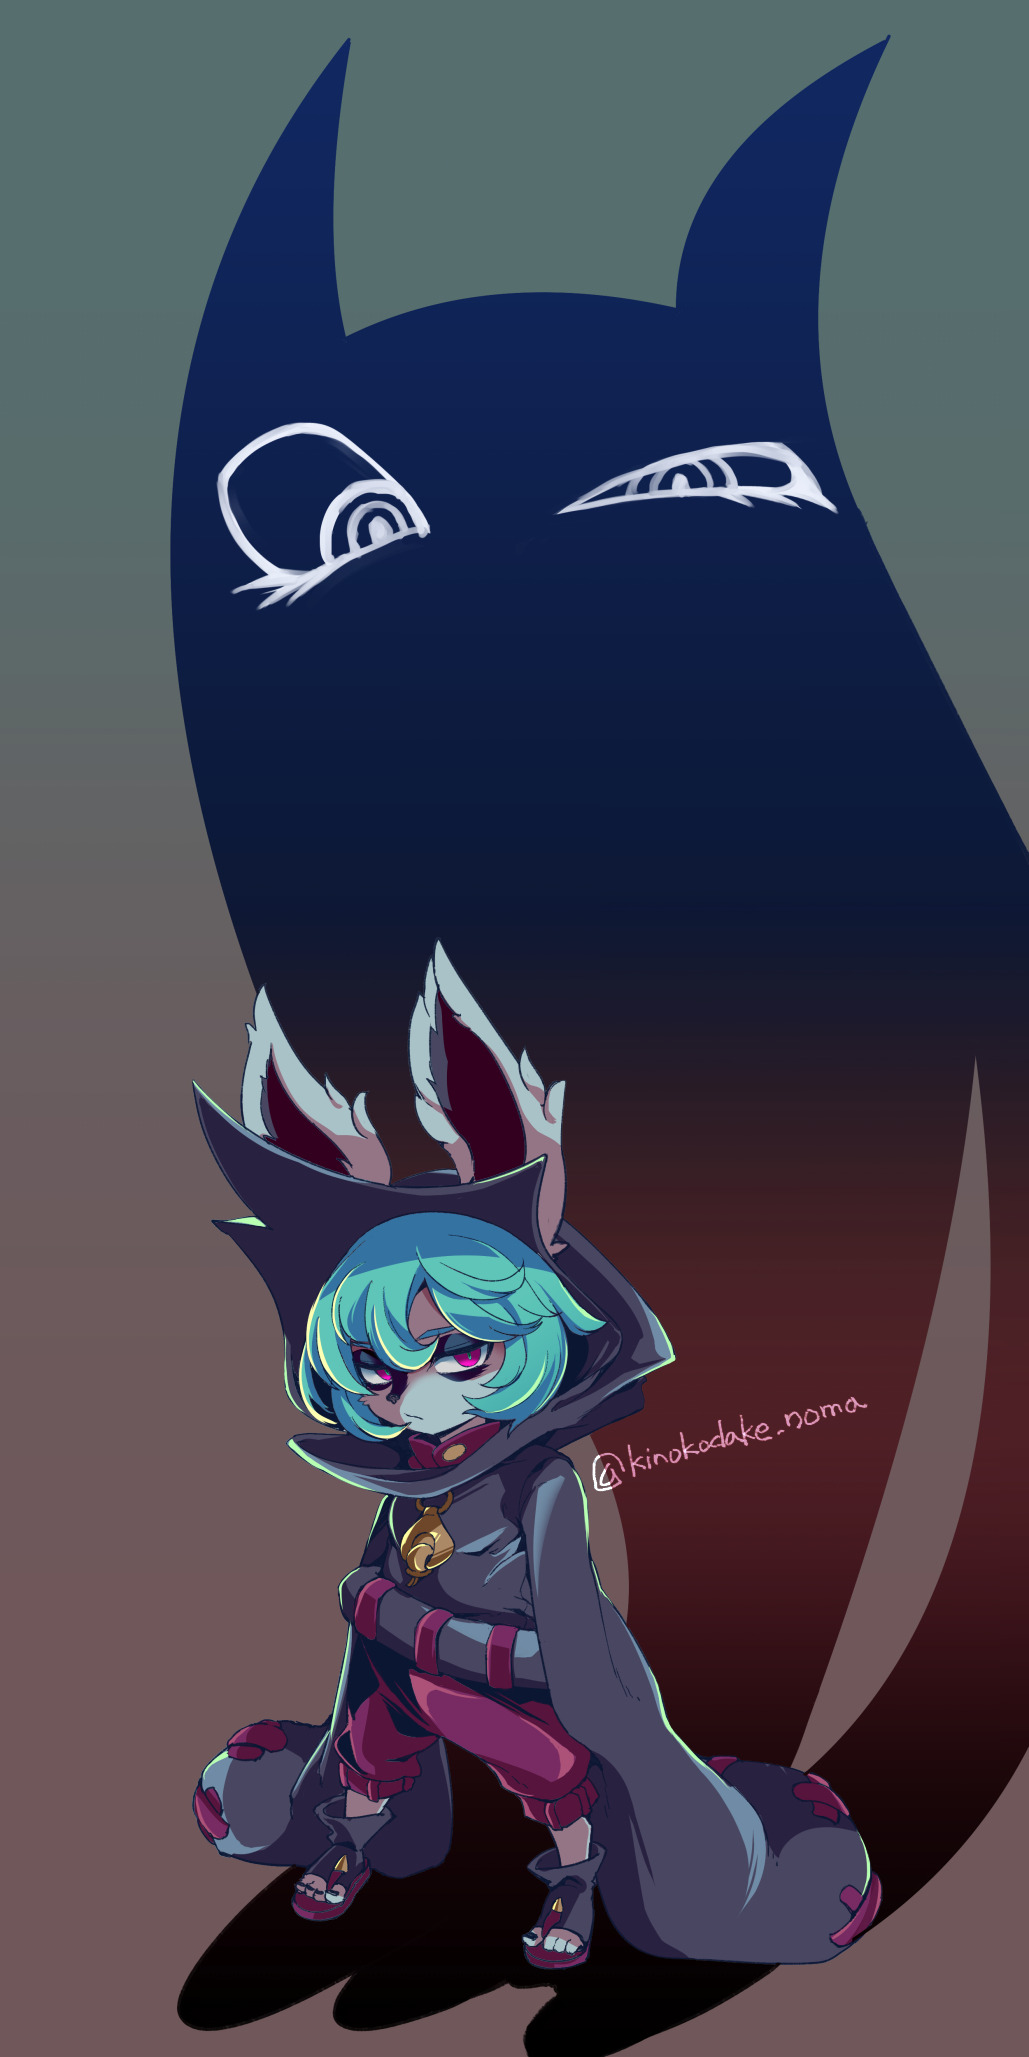

In [25]:
#!g1.1
# захардкодил, т.к. не думаю, что файл аннотации будет меняться полностью, только дополняться
demo_img = {
    'img_info': annotations['images'][9],
    'annotations': annotations['annotations'][14:15]
}

demo_img_source = Image.open(os.path.join(PATH_TO_DATASET_IMGS, demo_img['img_info']['file_name']))
demo_img_source # это на самом деле не тензор, а изображение(объект)!

Создаю пустое изображение для маски  
Сначала ширина указывается, затем высота.

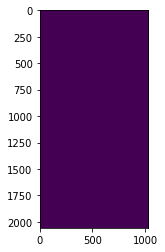

In [26]:
#!g1.1
s_img_height, s_img_width = demo_img['img_info']['height'], demo_img['img_info']['width']
new_img = Image.new('L', (s_img_width, s_img_height))
plt.imshow(new_img)

Рисую полигон по точкам аннотации, заполняя его индексом класса '1'

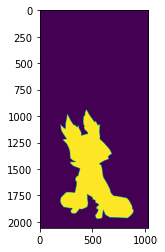

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: img1
  warnings.warn(message)


In [27]:
#!g1.1
img1 = ImageDraw.Draw(new_img)
img1.polygon(demo_img['annotations'][0]['segmentation'][0], fill=1)

plt.imshow(new_img)

Ну, собственно первая моя маска. (маска правильная)
**Перфекто манифик!**

Функция для рисования масок

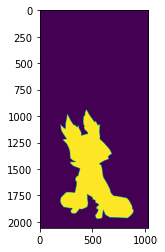

In [28]:
#!g1.1
def get_mask_img(width, height, img_annotations, bgc_cat_id):
  new_img = Image.new('L', (width, height))
  img_draw = ImageDraw.Draw(new_img)
  for annotation in img_annotations:
    segm, ann_cat_id = annotation['segmentation'][0], annotation['category_id']
    
    if ann_cat_id == bgc_cat_id:
      img_draw.polygon(segm, fill=0)
    else:
      img_draw.polygon(segm, fill=ann_cat_id)
  return new_img

img_mask = get_mask_img(s_img_width, s_img_height, demo_img['annotations'], BG_CAT_ID)
plt.imshow(img_mask)
plt.show()

In [29]:
#!g1.1
# сохранение созданной маски
!mkdir "vex_masks_ds"
img_mask.save(os.path.join(PATH_TO_DATASET_MASKS, 'test.png'))

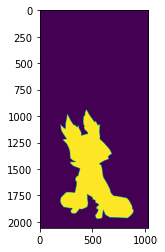

In [30]:
#!g1.1
# проверяю сохраненное
saved_mask = plt.imread(os.path.join(PATH_TO_DATASET_MASKS, 'test.png'))
plt.imshow(saved_mask)
plt.show()

Сохранение работает!

### Создание списка NxN аннотаций(изобр. и их масок)

Аннотации полигонов(масок) для объектов и для изображений - хранятся отдельно друг от друга.  
Для 1го изображения может быть несколько масок, но у каждой маски может быть только одно изображение.
___________
Изначально было 2 варианта списка:
- NxN "ссылочный список", где указывались только ключи\индексы связ. элементов
- обобщенный объект аннотаций, где была собрана вся нужная информация для создания масок и т.п.

Выбран был вариант NxN, как более универсальный и легкий(для восприятия, прежде всего)

In [31]:
#!g1.1
# связывание изображений и аннотаций к ним(таблица NxN индексов)
def get_nxn_img_annot_table(annotations):
  imgs_with_annotations = []
  for img_index, image in enumerate(annotations['images']):
    res_obj = { 'img_index': img_index, 'rel_anns': []}
    for ann_index, ann in enumerate(annotations['annotations']):
      if ann['image_id'] == image['id']:
        res_obj['rel_anns'].append(ann_index)
    imgs_with_annotations.append(res_obj)
  return imgs_with_annotations

get_nxn_img_annot_table(annotations)

[{'img_index': 0, 'rel_anns': [0]},
 {'img_index': 1, 'rel_anns': [1]},
 {'img_index': 2, 'rel_anns': [2]},
 {'img_index': 3, 'rel_anns': [3, 4, 5]},
 {'img_index': 4, 'rel_anns': [6]},
 {'img_index': 5, 'rel_anns': [7]},
 {'img_index': 6, 'rel_anns': [8]},
 {'img_index': 7, 'rel_anns': [9, 10]},
 {'img_index': 8, 'rel_anns': [11, 12, 13]},
 {'img_index': 9, 'rel_anns': [14]},
 {'img_index': 10, 'rel_anns': [15]},
 {'img_index': 11, 'rel_anns': [16]},
 {'img_index': 12, 'rel_anns': [17]},
 {'img_index': 13, 'rel_anns': [18, 19]},
 {'img_index': 14, 'rel_anns': [20, 21]},
 {'img_index': 15, 'rel_anns': [22]},
 {'img_index': 16, 'rel_anns': [23]},
 {'img_index': 17, 'rel_anns': [24, 25]},
 {'img_index': 18, 'rel_anns': [26]},
 {'img_index': 19, 'rel_anns': [27]},
 {'img_index': 20, 'rel_anns': [28]},
 {'img_index': 21, 'rel_anns': [29, 30, 31]},
 {'img_index': 22, 'rel_anns': [32]},
 {'img_index': 23, 'rel_anns': [33]},
 {'img_index': 24, 'rel_anns': [34]},
 {'img_index': 25, 'rel_anns':

### Генерация масок

In [32]:
#!g1.1
# генерирует маски по аннотации и сохраняет их в target_dir
# в одной маске - несколько классов, класс с bg_cat_id - красится в 0
# если в папке с масками уже есть с таким именем - ошибку не выдает,
# но что делает - хз

# Обязательно использовать png, т.к. jpeg изменяет значения пикселов
#(с 1 на 2, например), что будет мешать работать с сегментацией
def generate_masks(annotations, target_dir, bg_cat_id):
  # использую NxN таблицу
  imgs_anns = get_nxn_img_annot_table(annotations)
  for pair in imgs_anns:
    img = annotations['images'][pair['img_index']]
    h, w = img['height'], img['width']
    anns = [annotations['annotations'][ann_index] for ann_index in pair['rel_anns']]
    mask_img = get_mask_img(w, h, anns, bg_cat_id)
    mask_img.save(os.path.join(target_dir, f'{img["id"]}.png'))

In [33]:
#!g1.1
generate_masks(annotations, PATH_TO_DATASET_MASKS, BG_CAT_ID)

Проверяю сгенерированные маски

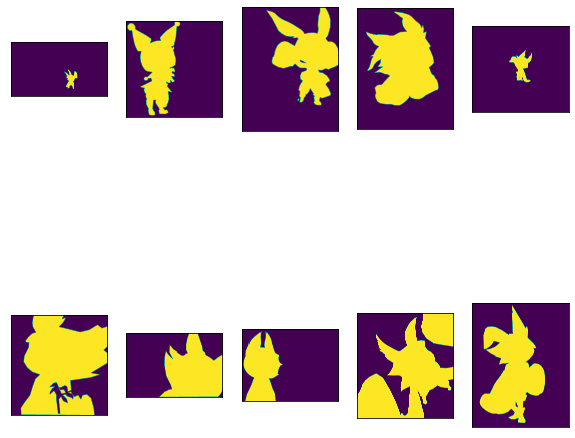

In [34]:
#!g1.1
# проверяю работу цикла выше, вывожу 10 масок
plt.figure(figsize=(10, 10))
for i in range(1, 11):
  plt.subplot(2, 5, i)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  img = plt.imread(os.path.join(PATH_TO_DATASET_MASKS, f'{i * 3}.png'))
  plt.imshow(img)

### Определяю подходящий ресайз для изображений
Чтобы удобно работать с моделями - придется задать ресайз всех изображений к какому нибудь значению, иначе батчи не собераются\модель не отображается и т.п.

Нужно найти среднюю и наиболее встречаемую пару HxW(аля мода) + нужно найти наиболее встречаемые пропорции.

In [35]:
#!g1.1
from PIL import Image

filenames = os.listdir(PATH_TO_DATASET_IMGS)
img_sizes = [] # [width, height]
for filename in filenames:
  img = Image.open(os.path.join(PATH_TO_DATASET_IMGS, filename))
  img_sizes.append(img.size)

In [36]:
#!g1.1
img_sizes = np.array(img_sizes)
proportions = img_sizes[:, 0] / img_sizes[:, 1]
proportions[:5]

array([1.48472906, 0.87708333, 1.77777778, 1.77777778, 1.77777778])

Пропорции: min 0.36, max 3.98705501618123
Пропорции: mean 1.1777187865615437, std 0.4800906952733273


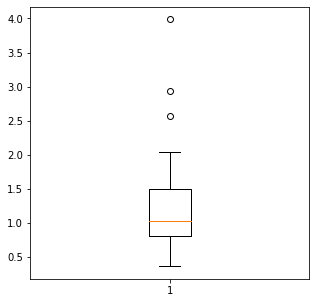

In [37]:
#!g1.1
print(f'Пропорции: min {proportions.min()}, max {proportions.max()}')
print(f'Пропорции: mean {proportions.mean()}, std {proportions.std()}')

plt.figure(figsize=(5, 5))
plt.boxplot(proportions)
plt.show()

Как видно по графику, оптимальный вариант ~~ 1, т.е. квадратное изображение

Width
Width: min 545, max 4224
Width: mean 1820.463687150838, std 837.6397224029545
Width: median 1750.0
Height
Height: min 432, max 4296
Height: mean 1698.7653631284916, std 854.1479276891715
Height: median 1500.0


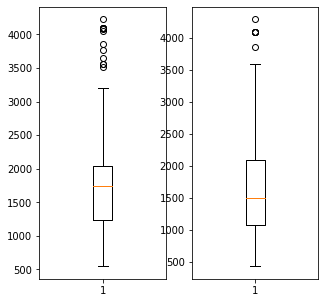

In [38]:
#!g1.1
plt.figure(figsize=(5, 5))

print('Width')
print(f'Width: min {img_sizes[:,0].min()}, max {img_sizes[:,0].max()}')
print(f'Width: mean {img_sizes[:,0].mean()}, std {img_sizes[:,0].std()}')
print(f'Width: median {np.median(img_sizes[:,0])}')

plt.subplot(1, 2, 1)
plt.boxplot(img_sizes[:,0])

print('Height')
print(f'Height: min {img_sizes[:,1].min()}, max {img_sizes[:,1].max()}')
print(f'Height: mean {img_sizes[:,1].mean()}, std {img_sizes[:,1].std()}')
print(f'Height: median {np.median(img_sizes[:,1])}')

plt.subplot(1, 2, 2)
plt.boxplot(img_sizes[:,1])
plt.show()

2 оптимальных варианта:

1) По верхней границе (2кX2к)

2) По среднему\медиане 1800 x 1500

Upd. Буду по верхней границе брать(т.е. 1)
____________
Также есть 3 варианта ресайза:

1) Ресайз больших изображений к 2к, а изображения меньше 2к - паддингом оборачивать, чтобы не портить изображение растяжением.

2) Ресайз всех изображений по одному правилу

В любом случае, ресайз будет идти с сохранением пропорций, по большей стороне, а паддинги заполняться 0.  
Upd. 1ый вариант будет лучше, я думаю.


Т.е. есть изображения вытянутые в высоту, есть в ширину, есть примерно квадратные.
Оптимальным вариантом, скорее всего, будут квадратные изображения, пусть это и исказит изображение.

Чтобы не искажать изображение - можно задать довольно высокое разрешение учитывающее оба варианта, а пустоты заполнять паддингами

In [39]:
#!g1.1
filenames = list(map(lambda x: os.path.join(PATH_TO_DATASET_IMGS, x), filenames))
filenames[0]

'vex_ds/101_League-of-Legends-фэндомы-Fizz-Vex-LoL-6929445.jpeg'

In [40]:
#!g1.1
# 2 типа для type - ['img', 'mask']
def tf_load_img(filepath, type):
  img_raw = tf.io.read_file(filepath)
  if type == 'img':
    img = tf.image.decode_jpeg(img_raw, channels=3)
  elif type == 'mask':
    img = tf.image.decode_png(img_raw, channels=1)
  else:
    return None
  img = tf.image.resize_with_pad(img, 512, 512)
  return img

Попытка загрузить изображения с ресайзом(212 штук всего) - вызывает падение по RAM  
Ну или почти падения. 10G RAM для ресайза 212 картинок, кек.

Проблема в tf.image.resize и компании.
_____
Поэтому батчи обязательны.

А в качестве демонстрации буду использовать группу из 4х изображений.


In [41]:
#!g1.1
# выборка изображений разных пропорций и размеров
img_indexes = [0, 1, 2, 5]
imgs = np.array(list(map(lambda x: tf_load_img(x, 'img'), filenames[:3] + [filenames[5]])))
print('Original:', img_sizes[img_indexes])
print('New shape', imgs.shape)

Original: [[1507 1015]
 [2526 2880]
 [1920 1080]
 [1200 1200]]
New shape (4, 512, 512, 3)


## Вспомогательные функции

#### Функция для вывода рез-та предсказания(в строку)
Функция выводящая в строку из 2-3х изображений: изображение, реальная маска и предсказанная маска.

In [42]:
#!g1.1
# вспомогательная функция для вывода изображения с маской и рез-т определения маски
def show_pred_result(display_list):
  plt.figure(figsize=(15, 15))

  titles = ['input', 'real', 'pred']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

#### Функция возвращающаю чекпоинт сохранения модели
Модели очень долго обучаются, не хотелось бы потерять результаты обучения, т.к. колаб может ГПУ выключить довольно быстро.

In [43]:
#!g1.1
def get_checkpoint(path_to_model):
  from tensorflow.keras.callbacks import ModelCheckpoint

  checkpoint = ModelCheckpoint(
      path_to_model,
      mode='min',
      monitor='val_loss',
      save_best_only=True,
      save_weights_only=False,
      verbose=1
  )
  return checkpoint

get_checkpoint('demopath')

#### Функция для визуализации кривых обучения по объекту `History`

In [44]:
#!g1.1
def vis_history(history):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='loss', c='blue')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.title('Loss')
  plt.legend()

  if history.history['accuracy']:
      plt.subplot(1, 2, 2)
      plt.plot(history.history['accuracy'], label='accuracy', c='orange')
      plt.plot(history.history['val_accuracy'], label='val_accuracy')
      plt.title('Accuracy')
  plt.legend()
  plt.show()

#### Функция отображения маски поверх изображения

In [45]:
#!g1.1
def show_img_with_mask(img, mask, class_index):
  cls_mask = (mask[:,:, class_index] > 0.5).astype(np.float32)
  seg_map_clr = plt.get_cmap('plasma')(cls_mask)[..., :3]
  plt.imshow(img * 0.5 + seg_map_clr * 0.5)
  plt.show()

#### Функция для проверки результатов работы FCN
Проверять буду на 3х элементах вал. датасета, для проверки работы предсказаний.

In [46]:
#!g1.1
# протестировать, собрал из 4х ячеек дублирующихся от модели к модели!
# стили row и cover.
# row - строка из 3х элементов: изобр., реал. маска и предск. маска
# cover - изображение созд. из изображения и наложенного на него предск. маской
def get_pred_result(model, example_ds, viz_style='row'):
  res = model.predict(example_ds)
  example_pics = [ [img[0], mask[0], pred] for (img, mask), pred in zip(example, res)]

  if viz_style == 'row':
    for display_item in example_pics:
      show_pred_result([
          display_item[0], 
          np.squeeze(display_item[1], axis=2), 
          np.squeeze(display_item[2][:,:,1:2], axis=2)]) # вывожу только первый(с Векс) канал пока
  elif viz_style == 'cover':
    for display_item in example_pics:
      show_img_with_mask(display_item[0], display_item[2], class_index=1)

## Собираю датасет для обучения(с аугментацией)

Создаю список файлов \['путь к файлу', 'путь к соотв. маске'\]

In [47]:
#!g1.1
img_mask_list = [ [os.path.join(PATH_TO_DATASET_IMGS, item['file_name']), 
                   os.path.join(PATH_TO_DATASET_MASKS, f'{item["id"]}.png')
                   ] for item in annotations['images'] ]
img_mask_list[:1]

[['vex_ds/101_League-of-Legends-фэндомы-Fizz-Vex-LoL-6929445.jpeg',
  'vex_masks_ds/1.png']]

Функция для `Dataset`, что будет по именам файлов возвращать изображение и его маску

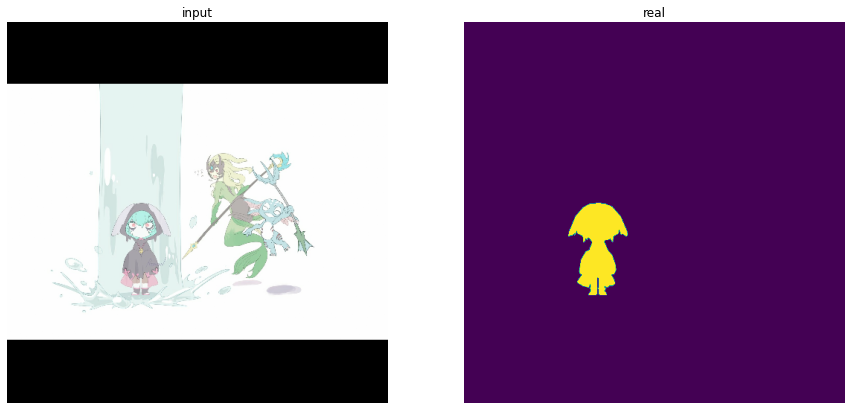

In [48]:
#!g1.1
def load_images_tensors(img_fp):
  # tf_load_img - моя функция из блока с ресайзом
  img_src = tf_load_img(img_fp[0], 'img') / np.float32(255.)
  mask_src = tf_load_img(img_fp[1], 'mask')
  return img_src, mask_src

demo_img, demo_mask = load_images_tensors(img_mask_list[0])

show_pred_result([demo_img, np.squeeze(demo_mask, axis=2)])

#### Аугментация(моделью)


Чтобы аугментацию одинаковую(с сохранением соотношения маски и изображения) провести - нужно применить два разных объекта ауг_модели с одинаковым `seed`.

In [49]:
#!g1.1
def aug_img_with_mask(img, mask, seed=10):
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Resizing
  from tensorflow.keras.layers import RandomFlip, RandomRotation
  from tensorflow.keras.layers import RandomCrop, RandomZoom, RandomTranslation

  aug_model = {}
  for model_key in ['img', 'mask']:
    aug_model[model_key] = Sequential([
      RandomFlip('horizontal_and_vertical', seed=seed),
      RandomZoom((-0.2, 0.2), (-0.2, 0.2), seed=seed),
      RandomTranslation((-0.2, 0.2), (-0.2, 0.2), seed=seed),
      RandomRotation(0.2, seed=seed),
      RandomCrop(256, 256, seed=seed),
      Resizing(img.shape[0], img.shape[1])
    ])

  aug_img, aug_mask = aug_model['img'](img), aug_model['mask'](mask)

  return aug_img, aug_mask

In [50]:
#!g1.1
aug_img, aug_mask = aug_img_with_mask(demo_img, demo_mask)
aug_img.shape, aug_mask.shape

(TensorShape([512, 512, 3]), TensorShape([512, 512, 1]))

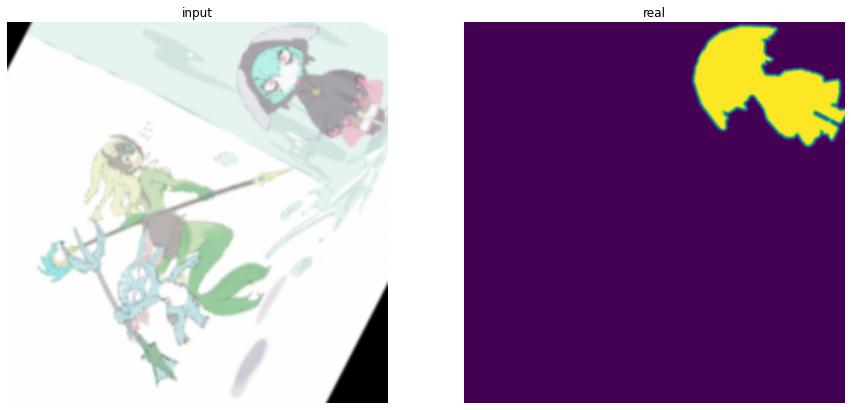

In [51]:
#!g1.1
show_pred_result([aug_img, np.squeeze(aug_mask, axis=2)])

#### Собственно создание датасетов

Создаю 2 отдельных датасета: тренировочный и валидационный.  
В валидационную выборку идет `BATCH_SIZE` * 3 изображений, все остальное в тренировочный.

Кратко идея такая:  
1. Из списка "путь к изображению и соотвю маске" создается объект `Dataset`
2. Вместо аннотаций подгружаются соотв. пары изображение + маска(одна маска на все классы)
3. Датасет перемешивается и кешируется(обязательно!!!)
4. (Для трен. датасета) Датасет увеличивается в N раз, к нему применяется аугментация и формируются батчи


In [89]:
#!g1.1
from tensorflow.data import Dataset

dataset = (Dataset
           .from_tensor_slices(img_mask_list)
)

val_size =  BATCH_SIZE * 3 # картинок мало, если в процентах брать, то полбатча отбрасывается(
train_size = len(dataset) - val_size
print(train_size, val_size)

train_ds = (dataset
                 .take(train_size)
                 .map(load_images_tensors)
                 .shuffle(train_size)
                 .cache()
                 .repeat(20)
                 .map(aug_img_with_mask)
                 .batch(BATCH_SIZE, drop_remainder=True))

val_ds = (dataset
               .skip(train_size)
               .take(val_size)
               .map(load_images_tensors)
               .cache()
               .batch(BATCH_SIZE, drop_remainder=True))

print(len(train_ds), len(val_ds))

155 24
Cause: Unable to locate the source code of <function load_images_tensors at 0x7f459c3b09d0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function load_images_tensors at 0x7f459c3b09d0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function load_images_tensors at 0x7f459c3b09d0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function aug_img_with_mask at 0x7f45f0242040>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the fu

Cause: Unable to locate the source code of <function aug_img_with_mask at 0x7f45f0242040>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function aug_img_with_mask at 0x7f45f0242040>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
387 3


INFO:tensorflow:Assets written to: ram://3d55da50-f530-4cdc-b5b1-377653c928ab/assets


INFO:tensorflow:Assets written to: ram://3d55da50-f530-4cdc-b5b1-377653c928ab/assets


INFO:tensorflow:Assets written to: ram://e3b9c34c-026d-426c-8e01-9923a97488be/assets


INFO:tensorflow:Assets written to: ram://e3b9c34c-026d-426c-8e01-9923a97488be/assets
/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: dataset, train_ds, val_ds
  warnings.warn(message)


Инициализация(для кеширования) и вывод изображений из датасетов

2022-09-06 14:51:07.756293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-09-06 14:51:07.772271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-09-06 14:51:07.788858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-09-06 14:51:07.800288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


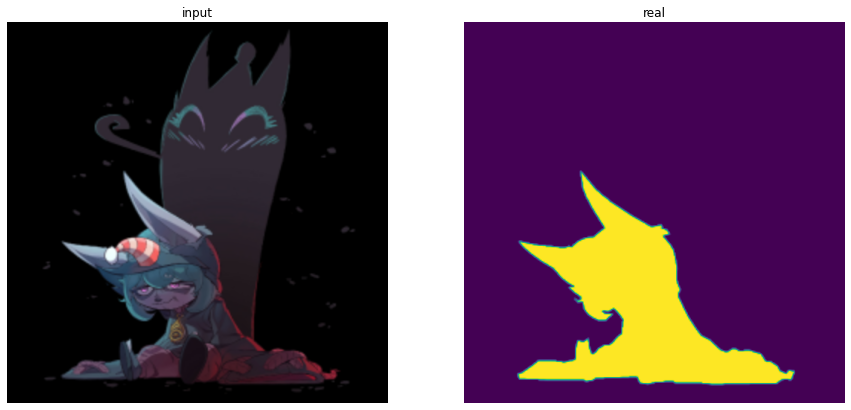

2022-09-06 14:51:13.165604: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


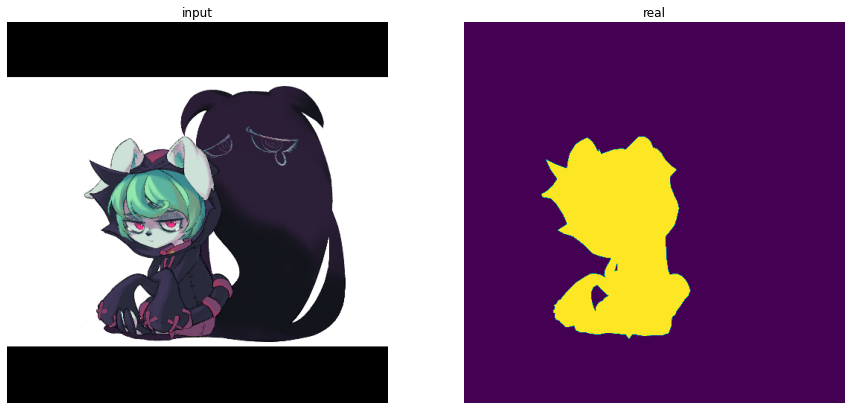

2022-09-06 14:51:13.813868: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


INFO:tensorflow:Assets written to: ram://932c2aa3-c714-4f16-b234-58582b1ede78/assets


INFO:tensorflow:Assets written to: ram://932c2aa3-c714-4f16-b234-58582b1ede78/assets


INFO:tensorflow:Assets written to: ram://98e5eff5-a0ff-4294-8067-9f0f36467067/assets


INFO:tensorflow:Assets written to: ram://98e5eff5-a0ff-4294-8067-9f0f36467067/assets
/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: dataset, train_ds, val_ds
  warnings.warn(message)


In [90]:
#!g1.1
for img, mask in train_ds:
  show_pred_result([img[0], np.squeeze(mask[0], axis=2)])
  break

for img, mask in val_ds:
  show_pred_result([img[0], np.squeeze(mask[0], axis=2)])
  break

Дополнительно инициал. датасет example, для визуализации работы модели по построению сегмент. маски.

In [91]:
#!g1.1
example = val_ds.skip(1).take(1).cache()

INFO:tensorflow:Assets written to: ram://62d492e2-793b-4e2d-9766-d1cdae4c6ed8/assets


INFO:tensorflow:Assets written to: ram://62d492e2-793b-4e2d-9766-d1cdae4c6ed8/assets


INFO:tensorflow:Assets written to: ram://c04aa835-174e-405c-ae8e-89cf532b9f87/assets


INFO:tensorflow:Assets written to: ram://c04aa835-174e-405c-ae8e-89cf532b9f87/assets
/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: dataset, example, train_ds, val_ds
  warnings.warn(message)


## Простая модель FCN(без декодера, с ресайзом)


In [57]:
#!g1.1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.activations import softmax

In [182]:
#!g1.1
class SimpleFCN(Model):

  def __init__(self):
    super().__init__()
    
    self.conv1 = Conv2D(64, (3, 3), padding='same', activation='relu')
    self.conv2 = Conv2D(64, (3, 3), padding='same', activation='relu')
    self.conv3 = Conv2D(128, (3, 3), padding='same', activation='relu')
    self.conv4 = Conv2D(128, (3, 3), padding='same', activation='relu')
    self.conv5 = Conv2D(256, (3, 3), padding='same', activation='relu')
    self.conv6 = Conv2D(256, (3, 3), padding='same', activation='relu')
    self.conv7 = Conv2D(512, (3, 3), padding='same', activation='relu')
    self.conv8 = Conv2D(512, (3, 3), padding='same', activation='relu')
    self.out_layer = Conv2D(2, (3, 3), padding='same', activation=None)

    self.maxpooling = MaxPooling2D()

  def call(self, X):
      out = self.conv1(X)
      out = self.conv2(out)
      out = self.maxpooling(out)

      out = self.conv3(out)
      out = self.conv4(out)
      out = self.maxpooling(out)

      out = self.conv5(out)
      out = self.conv6(out)
      out = self.maxpooling(out)

      out = self.conv7(out)
      out = self.conv8(out)
      out = self.maxpooling(out)

      out = self.out_layer(out)
      out = tf.image.resize(out, (X.shape[1], X.shape[2]), tf.image.ResizeMethod.BILINEAR)
      out = softmax(out)

      return out

s_fcn_model = SimpleFCN()

2022-09-02 20:31:30.449979: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-02 20:31:41.079498: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-02 20:31:44.717608: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:222] Using CUDA malloc Async allocator for GPU: 0
2022-09-02 20:31:44.723417: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30989 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci 

In [186]:
#!g1.1
s_fcn_model.compile('Adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: dataset, train_ds, val_ds
  warnings.warn(message)


In [187]:
#!g1.1
# собираю модель с шейпами входа в датасет(0ой элемент датасета)
s_fcn_model.build(train_ds.element_spec[0].shape)
s_fcn_model.summary()

Model: "simple_fcn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  1792      
                                                                 
 conv2d_1 (Conv2D)           multiple                  36928     
                                                                 
 conv2d_2 (Conv2D)           multiple                  73856     
                                                                 
 conv2d_3 (Conv2D)           multiple                  147584    
                                                                 
 conv2d_4 (Conv2D)           multiple                  295168    
                                                                 
 conv2d_5 (Conv2D)           multiple                  590080    
                                                                 
 conv2d_6 (Conv2D)           multiple                  1

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: dataset, s_fcn_model, train_ds, val_ds
  warnings.warn(message)


С текущим learning_rate(если в этом проблема конечно) - модель после 5 эпох начинает "накапливать" лосс.  
С 0.02 лосса она на 5-7 эпохе она улетает на 0.2 лосс, а следующая эпоха 0.4 - дальше не смотрел.

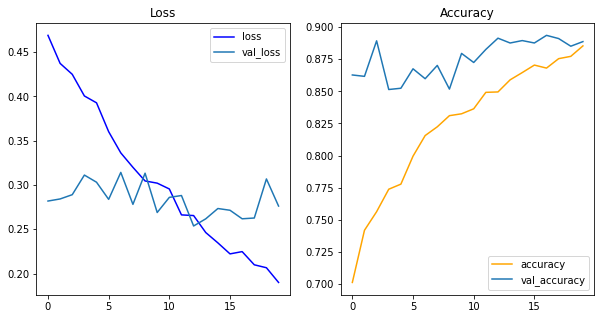

387/387 [==============================] - 301s 778ms/step - loss: 0.3601 - accuracy: 0.7996 - val_loss: 0.2838 - val_accuracy: 0.8676
Epoch 7/20
387/387 [==============================] - 301s 778ms/step - loss: 0.3362 - accuracy: 0.8156 - val_loss: 0.3142 - val_accuracy: 0.8599
Epoch 8/20
387/387 [==============================] - 301s 779ms/step - loss: 0.3199 - accuracy: 0.8224 - val_loss: 0.2781 - val_accuracy: 0.8702
Epoch 9/20
387/387 [==============================] - 301s 779ms/step - loss: 0.3045 - accuracy: 0.8311 - val_loss: 0.3133 - val_accuracy: 0.8518
Epoch 10/20
387/387 [==============================] - 301s 776ms/step - loss: 0.3021 - accuracy: 0.8325 - val_loss: 0.2689 - val_accuracy: 0.8796
Epoch 11/20
387/387 [==============================] - 301s 778ms/step - loss: 0.2955 - accuracy: 0.8364 - val_loss: 0.2860 - val_accuracy: 0.8725
Epoch 12/20
387/387 [==============================] - 301s 778ms/step - loss: 0.2662 - accuracy: 0.8492 - val_loss: 0.2881 - val_acc

INFO:tensorflow:Assets written to: saved_models_vex_segm/Simple_FCN/assets
INFO:tensorflow:Assets written to: ram://7eb0fb65-5ae0-47b0-8059-5d8fa9cd4032/assets
INFO:tensorflow:Assets written to: ram://0b2eaf78-d9a0-4b75-a016-834fb9681c86/assets
/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: dataset, train_ds, val_ds
  warnings.warn(message)


In [189]:
#!g1.1
if PATH_TO_MODEL['Simple_FCN']['is_saved'] == True:
  s_fcn_model.load_weights(PATH_TO_MODEL['Simple_FCN']['path'])
else:
  history = s_fcn_model.fit(train_ds, epochs=20, validation_data=val_ds)
  vis_history(history)
  s_fcn_model.save(PATH_TO_MODEL['Simple_FCN']['path'])

Обязательно запускать на GPU! Без Gpu - либо падает на памяти, либо выдает ошибку вида "не могу просчитать градиент".  
Понятное дело, что без просчета градиента - смысла в обучении 0
__________
Пришлось размер картинки уменьшить с 2к до 0.5к, т.к. обучение длилось 35м на эпоху, при размере выборки ~~ 1600 картинок.

Зависимость длительности обучения от размера изображения(на 1 эпоху, при 2120 картинках, GPU):  
2000х2000 - 35м  
1000х1000 - 8.5м  
512х512 - 3м  

Поэтому, доводить модель до адекватной\аккуратной формы буду на 512х512, а финальную модель(UnetFCN+) буду учить на больших картинках(1к или мб даже 2к размером)

#### Проверка результатов модели

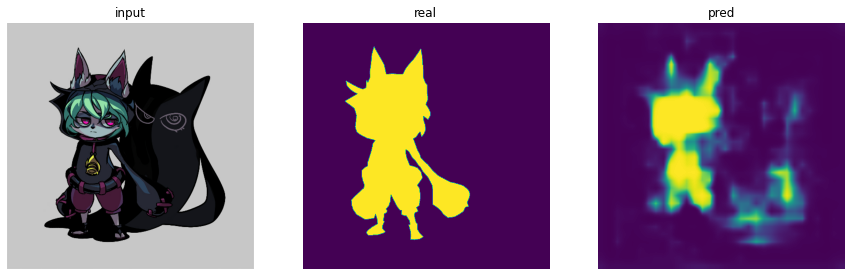

1/1 [==============================] - 10s 10s/step
INFO:tensorflow:Assets written to: ram://467b475d-410f-452d-9c48-ef53e13322c5/assets
INFO:tensorflow:Assets written to: ram://60e524d9-bc7a-4183-9d2b-a7c4b3d66ced/assets


2022-09-02 22:49:37.070734: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8500
2022-09-02 22:49:41.515266: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
INFO:tensorflow:Assets written to: ram://467b475d-410f-452d-9c48-ef53e13322c5/assets
INFO:tensorflow:Assets written to: ram://60e524d9-bc7a-4183-9d2b-a7c4b3d66ced/assets
/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: dataset, example, train_ds, val_ds
  warnings.warn(message)


In [199]:
#!g1.1
get_pred_result(s_fcn_model, example)

Результаты слабоватые, как видно.

## FCN с декодером

In [236]:
#!g1.1
from tensorflow.keras.layers import UpSampling2D

INFO:tensorflow:Assets written to: ram://7b1885b1-29ec-4e23-ada1-5be63fbbed29/assets


INFO:tensorflow:Assets written to: ram://7b1885b1-29ec-4e23-ada1-5be63fbbed29/assets


In [237]:
#!g1.1
class Enc_Dec_FCN(Model):

  def __init__(self, num_classes):
    super().__init__()

    self.conv_e_11 = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')
    self.conv_e_12 = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')

    self.conv_e_21 = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')
    self.conv_e_22 = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')

    self.conv_e_31 = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')
    self.conv_e_32 = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')

    self.conv_bn_11 = Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu')
    self.conv_bn_12 = Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu')
    self.conv_bn_13 = Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu')

    self.conv_d_11 = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')
    self.conv_d_12 = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')

    self.conv_d_21 = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')
    self.conv_d_22 = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')

    self.conv_d_31 = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')
    self.conv_d_32 = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')

    self.out_layer = Conv2D(2, kernel_size=(3, 3), padding='same', activation='softmax')

    self.pool = MaxPooling2D()
    self.unpool = UpSampling2D()

  def call(self, X):
    out = self.conv_e_11(X)
    out = self.conv_e_12(out)
    out = self.pool(out)

    out = self.conv_e_21(out)
    out = self.conv_e_22(out)
    out = self.pool(out)

    out = self.conv_e_31(out)
    out = self.conv_e_32(out)
    out = self.pool(out)

    out = self.conv_bn_11(out)
    out = self.conv_bn_12(out)
    out = self.conv_bn_13(out)

    out = self.unpool(out)
    out = self.conv_d_11(out)
    out = self.conv_d_12(out)

    out = self.unpool(out)
    out = self.conv_d_21(out)
    out = self.conv_d_22(out)

    out = self.unpool(out)
    out = self.conv_d_31(out)
    out = self.conv_d_32(out)

    out = self.out_layer(out)

    return out

enc_dec_model = Enc_Dec_FCN(num_classes=2)

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: dataset, example, train_ds, val_ds
  warnings.warn(message)


In [238]:
#!g1.1
enc_dec_model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: dataset, example, train_ds, val_ds
  warnings.warn(message)


In [239]:
#!g1.1
enc_dec_model.build(train_ds.element_spec[0].shape)
enc_dec_model.summary()

Model: "enc__dec_fcn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  1792      
                                                                 
 conv2d_1 (Conv2D)           multiple                  36928     
                                                                 
 conv2d_2 (Conv2D)           multiple                  73856     
                                                                 
 conv2d_3 (Conv2D)           multiple                  147584    
                                                                 
 conv2d_4 (Conv2D)           multiple                  295168    
                                                                 
 conv2d_5 (Conv2D)           multiple                  590080    
                                                                 
 conv2d_6 (Conv2D)           multiple                 

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: dataset, enc_dec_model, example, train_ds, val_ds
  warnings.warn(message)


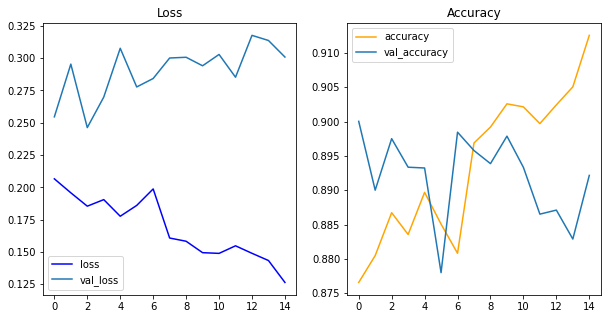

387/387 [==============================] - ETA: 0s - loss: 0.2066 - accuracy: 0.8766
Epoch 1: val_loss improved from inf to 0.25452, saving model to saved_models_vex_segm/Enc_Dec_FCN
INFO:tensorflow:Assets written to: saved_models_vex_segm/Enc_Dec_FCN/assets
387/387 [==============================] - 402s 1s/step - loss: 0.2066 - accuracy: 0.8766 - val_loss: 0.2545 - val_accuracy: 0.9000
Epoch 2/15
387/387 [==============================] - ETA: 0s - loss: 0.1958 - accuracy: 0.8805
Epoch 2: val_loss did not improve from 0.25452
387/387 [==============================] - 399s 1s/step - loss: 0.1958 - accuracy: 0.8805 - val_loss: 0.2953 - val_accuracy: 0.8900
Epoch 3/15
387/387 [==============================] - ETA: 0s - loss: 0.1854 - accuracy: 0.8867
Epoch 3: val_loss improved from 0.25452 to 0.24620, saving model to saved_models_vex_segm/Enc_Dec_FCN
INFO:tensorflow:Assets written to: saved_models_vex_segm/Enc_Dec_FCN/assets
387/387 [==============================] - 402s 1s/step - lo

INFO:tensorflow:Assets written to: saved_models_vex_segm/Enc_Dec_FCN/assets
INFO:tensorflow:Assets written to: saved_models_vex_segm/Enc_Dec_FCN/assets
INFO:tensorflow:Assets written to: saved_models_vex_segm/Enc_Dec_FCN/assets
INFO:tensorflow:Assets written to: ram://7677415b-17ad-45bb-864c-23039eaeead5/assets
INFO:tensorflow:Assets written to: ram://42643274-c594-43e7-b5e9-f92a33a6da00/assets
/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: dataset, example, train_ds, val_ds
  warnings.warn(message)


In [246]:
#!g1.1
if PATH_TO_MODEL['Enc_Dec_FCN']['is_saved'] == True:
  enc_dec_model.load_weights(PATH_TO_MODEL['Enc_Dec_FCN']['path'])
else:
  checkpoint = get_checkpoint(PATH_TO_MODEL['Enc_Dec_FCN']['path'])
  history = enc_dec_model.fit(train_ds, epochs=15, callbacks=[checkpoint], validation_data=val_ds)
  vis_history(history)
  enc_dec_model.save(PATH_TO_MODEL['Enc_Dec_FCN']['path'])

#### Проверка результатов модели

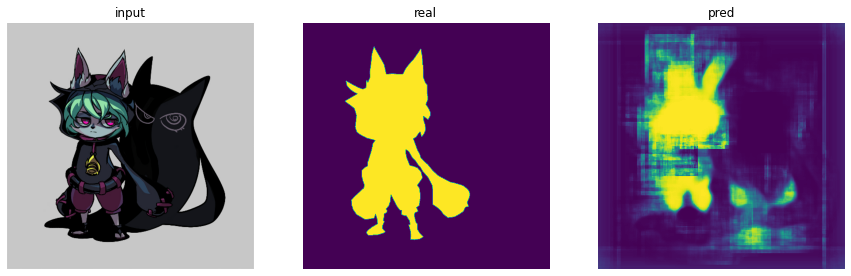

1/1 [==============================] - 11s 11s/step
INFO:tensorflow:Assets written to: ram://132bae6a-8697-439e-a04e-d0a4806f77ac/assets
INFO:tensorflow:Assets written to: ram://293c3673-2048-40a4-863b-4b0cb6ac2206/assets


2022-09-03 19:56:34.552470: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8500
2022-09-03 19:56:40.287362: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
INFO:tensorflow:Assets written to: ram://132bae6a-8697-439e-a04e-d0a4806f77ac/assets
INFO:tensorflow:Assets written to: ram://293c3673-2048-40a4-863b-4b0cb6ac2206/assets
/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: dataset, example, train_ds, val_ds
  warnings.warn(message)


In [253]:
#!g1.1
get_pred_result(enc_dec_model, example)

## Уточнение задачи.
Обе модели(SimpleFcn и Enc_Dec_FCN) - показали себя очень слабо на тек. момент, они не могут научиться отличать Векс от фона.
При этом, сама модель может запомнить\научиться создавать маски по знакомым изображениям, т.е., предположительно, ей хватает параметров чтобы обучиться, но она ПЕРЕобучается.

Есть подозрение, что задача слишком сложна для нейронки, поэтому нужно проверить, что задача решаемая последними "стейт-оф-арт" моделями сегментации.   
И если они могут справиться на приемлимом уровне - тогда уже приводить текущие FCN модели к какому то адекватному результату.

### Поиск state-of-art моделей
1. tensorflow_examples.models
2. Пример отсюда
https://www.tensorflow.org/tutorials/images/segmentation
Кратко - для энкодера возьмите обученную модель, декодер создайте сами
3. https://github.com/tensorflow/models
Огромный набор готовых моделей от тензорфлоу, в т.ч. и для сегментации\детекции. (я вроде бы какие то из них частнично использовал в обучении)
4. https://github.com/divamgupta/image-segmentation-keras
Набор обученных моделей
5. https://github.com/qubvel/segmentation_models
Набор обученных моделей 2(больше звезд, чем у предыдущего)
6. Пример полной модели
https://keras.io/examples/vision/oxford_pets_image_segmentation/
7. Как я понял, если все приемы навертеть на FCN(скипы, ASPP и т.п.) - получится вполне себе современная сетка, не сильно хуже остальных.
Т.е. можно и свою реализовывать, по схеме U-net.

Зы. Мб у меня недостаточно глубокая вышла.(2)  
В стейт-оф-арт машинах используется разрешение картинок около 224х224, у меня же в 2 раза больше.  
При этом, их модели глубже моих. Т.е. у меня все с точностью наоборот хд.

Если посчитать, то на батлнек приходится зона в 256(! именно 256, а не 256х256), как 4^4(при паддингах `same` и `pooling 2x2`) = 256 квадр. область. Это область размера 16х16, что очень и очень мало.  
Логично было бы увеличить хотя бы до **64x64**, чтобы у сети было достаточно много информации для прав. предсказания.

И лучше рисовать в функциональном стиле имха, чтобы размерности было видно.

Upd:

3. tensorflow-models - довольно сложной выглядит для быстрого использования, т.е. придется долго(потенциально) разбираться, о чем там речь, прежде чем я что то смогу запустить.
Разобраться стоит, думаю. Но позжей.
6. Аналогичен 7, т.к. в обоих случаях речь о полноценной U-net.  
Пункт 2. - та же Unet, но энкодер берется файнтюнингом.

## Пробую заранее созданную сегм. модель(п.5 из списка выше)

Использовать буду модель Unet архитектуры, с предобученными на ImageNet модели ResNet, т.к. обе архитектуры(Unet и ResNet) - мне знакомы как простые и стабильные.

In [318]:
#!g1.1
%pip install -U segmentation-models

Defaulting to user installation because normal site-packages is not writeable


In [70]:
#!g1.1
import segmentation_models as sm
sm.set_framework('tf.keras')

Segmentation Models: using `keras` framework.


INFO:tensorflow:Assets written to: ram://384ef823-64f5-4082-bc35-fc8629f41ae2/assets


INFO:tensorflow:Assets written to: ram://384ef823-64f5-4082-bc35-fc8629f41ae2/assets


In [71]:
#!g1.1
BACKBONE = 'resnet34'

INFO:tensorflow:Assets written to: ram://9ab747d2-b581-44c9-a937-aebe379e59b4/assets


INFO:tensorflow:Assets written to: ram://9ab747d2-b581-44c9-a937-aebe379e59b4/assets


In [72]:
#!g1.1
cool_model = sm.Unet('resnet34', encoder_weights='imagenet', classes=2, activation='softmax')

INFO:tensorflow:Assets written to: ram://474a352e-f8aa-4dac-8708-5c2ed873ffda/assets


INFO:tensorflow:Assets written to: ram://474a352e-f8aa-4dac-8708-5c2ed873ffda/assets


INFO:tensorflow:Assets written to: ram://d2d4f1e3-b233-4983-8de8-08f61e562831/assets


INFO:tensorflow:Assets written to: ram://d2d4f1e3-b233-4983-8de8-08f61e562831/assets


INFO:tensorflow:Assets written to: ram://6a3bd95e-9eac-4c4d-b884-746bb655bfa8/assets


INFO:tensorflow:Assets written to: ram://6a3bd95e-9eac-4c4d-b884-746bb655bfa8/assets


In [73]:
#!g1.1
cool_model.compile('Adam', 'sparse_categorical_crossentropy', metrics=[sm.metrics.iou_score])

INFO:tensorflow:Assets written to: ram://8dac3c5c-19f3-4364-abef-da66f1406224/assets


INFO:tensorflow:Assets written to: ram://8dac3c5c-19f3-4364-abef-da66f1406224/assets


INFO:tensorflow:Assets written to: ram://a045e7dc-06a7-497d-b597-c38d8b8308c5/assets


INFO:tensorflow:Assets written to: ram://a045e7dc-06a7-497d-b597-c38d8b8308c5/assets


INFO:tensorflow:Assets written to: ram://5a07a81b-2c55-4944-9328-ef5894733e76/assets


INFO:tensorflow:Assets written to: ram://5a07a81b-2c55-4944-9328-ef5894733e76/assets


In [74]:
#!g1.1
if PATH_TO_MODEL['Trained_Unet']['is_saved']:
  cool_model.load_weights(PATH_TO_MODEL['Trained_Unet']['path'])
else:
  checkpoint = get_checkpoint(PATH_TO_MODEL['Trained_Unet']['path'])
  history = cool_model.fit(train_ds, epochs=EPOCHS, callbacks=[checkpoint], validation_data=val_ds)
  vis_history(history)

2022-09-06 14:04:13.768369: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open saved_models_vex_segm/Trained_Unet: FAILED_PRECONDITION: saved_models_vex_segm/Trained_Unet; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


INFO:tensorflow:Assets written to: ram://5726ed42-3af7-43e6-b9cb-f2537b75798f/assets


INFO:tensorflow:Assets written to: ram://5726ed42-3af7-43e6-b9cb-f2537b75798f/assets


INFO:tensorflow:Assets written to: ram://842c3337-9e6c-42e5-b2b5-a30127799f60/assets


INFO:tensorflow:Assets written to: ram://842c3337-9e6c-42e5-b2b5-a30127799f60/assets


INFO:tensorflow:Assets written to: ram://33bef1d2-547e-49e9-a906-97f17c147db8/assets


INFO:tensorflow:Assets written to: ram://33bef1d2-547e-49e9-a906-97f17c147db8/assets


#### Проверка результатов модели

2022-09-06 14:05:24.906859: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8500


1/1 [==============================] - 11s 11s/step


2022-09-06 14:05:29.558201: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


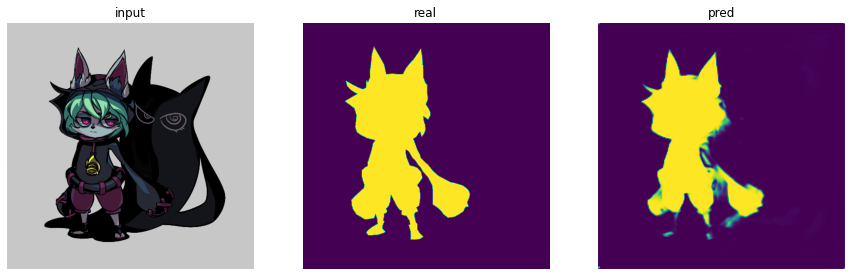

INFO:tensorflow:Assets written to: ram://92cabd67-01b6-4ed2-9653-3d5d087868b3/assets


INFO:tensorflow:Assets written to: ram://92cabd67-01b6-4ed2-9653-3d5d087868b3/assets


INFO:tensorflow:Assets written to: ram://a2537ba0-dcf3-4d5b-8425-f7423ad212d8/assets


INFO:tensorflow:Assets written to: ram://a2537ba0-dcf3-4d5b-8425-f7423ad212d8/assets


INFO:tensorflow:Assets written to: ram://d1737f83-f05c-4c9d-8b2f-54cb539c3c15/assets


INFO:tensorflow:Assets written to: ram://d1737f83-f05c-4c9d-8b2f-54cb539c3c15/assets
/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: dataset, example, train_ds, val_ds
  warnings.warn(message)


In [75]:
#!g1.1
get_pred_result(cool_model, example)

Результаты очень хорошие, в сравнении с моими моделями :'c

In [76]:
#!g1.1
cool_model.evaluate(val_ds)

3/3 [==============================] - 3s 120ms/step - loss: 0.1354 - iou_score: 0.4116


[0.13538898527622223, 0.4116317331790924]

INFO:tensorflow:Assets written to: ram://0aa317f3-aebd-48cd-8ce8-6bd94733a4e5/assets


INFO:tensorflow:Assets written to: ram://0aa317f3-aebd-48cd-8ce8-6bd94733a4e5/assets


INFO:tensorflow:Assets written to: ram://a873219c-93f0-4855-9c34-d89317b81f8f/assets


INFO:tensorflow:Assets written to: ram://a873219c-93f0-4855-9c34-d89317b81f8f/assets


INFO:tensorflow:Assets written to: ram://86a42d69-7eac-440a-9421-76945f14cb23/assets


INFO:tensorflow:Assets written to: ram://86a42d69-7eac-440a-9421-76945f14cb23/assets
/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: dataset, example, train_ds, val_ds
  warnings.warn(message)


Ситуация довольно печальная, даже импортированная модель не может сегментировать лучше лосса в 0.21.  
При этом уже после 30 эпохи модель переобучилась.  

Т.е. если подытожить - даже эти хитроумные модели оказались не намного лучше моих поделок, хотя визуально и выглядит сильно лучше.

## Что еще можно сделать будет
1. Попробовать разные модели из списка выше, разные реализации.
2. Конкретно в библиотеке segmentation_models - разные `BACKBONE`, с заморозкой\без оной.
3. Попробовать разный подход к маскам - sparse\изолированные binary.  
Последние дают доступ к большим вариантам loss функции.
4. Разные loss попробовать.
5. Разные разрешения картинок попробовать.

Во всех пунктах - использовать разные гиперпараметры можно и т.п.  
Опять же, в рамках этой же задачи - можно попробовать поиспользовать KerasTuner, который будет эти гиперпараметры подбирать.

Заниматься этим можно оч. долго(месяц точно)

## Реализация образцовой модели Unet

In [55]:
#!g1.1
from tensorflow.keras.layers import Input, Concatenate, Conv2DTranspose

In [58]:
#!g1.1
filter_sizes = [64, 128, 256, 512]
bottleneck_kernel_size = 1024

input_layer = Input(shape=(512, 512, 3))

# Encoder
out = input_layer
conv_block_output = []
for filter_size in filter_sizes:
  out = Conv2D(filter_size, 3, activation='relu', padding='same')(out)
  out = Conv2D(filter_size, 3, activation='relu', padding='same')(out)
  conv_block_output.append(out)
  out = MaxPooling2D()(out)

# bottleneck
out = Conv2D(bottleneck_kernel_size, 3, activation='relu', padding='same')(out)
out = Conv2D(bottleneck_kernel_size, 3, activation='relu', padding='same')(out)

# aspp block
enc_out = out
dil_1 = Conv2D(512, 1, padding='same', activation='relu', name='aspp_1')(enc_out)
dil_8 = Conv2D(512, 1, padding='same', dilation_rate=8, activation='relu', name='aspp_dil_8')(enc_out)
dil_16 = Conv2D(512, 1, padding='same', dilation_rate=16, activation='relu', name='aspp_dil_16')(enc_out)
dil_32 = Conv2D(512, 1, padding='same', dilation_rate=32, activation='relu', name='aspp_dil_32')(enc_out)
dil_concat = Concatenate(axis=3)([dil_1, dil_8, dil_16, dil_32])
dil_out = Conv2D(512, 1, padding='same', activation='relu', name='aspp_out')(dil_concat)

# Decoder
out = dil_out
for filter_size in reversed(filter_sizes):
  out = Conv2DTranspose(filter_size, 3, strides=2, padding='same', activation='relu')(out)
  out = Concatenate(axis=3)([out, conv_block_output.pop(-1)])
  out = Conv2D(filter_size, 3, activation='relu', padding='same')(out)
  out = Conv2D(filter_size, 3, activation='relu', padding='same')(out)

# output
output = Conv2D(2, 3, padding='same', activation='softmax', name='output')(out)

my_unet_model = Model(inputs=input_layer, outputs=output)
my_unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

INFO:tensorflow:Assets written to: ram://ca5d2f9e-088e-4221-8a36-bc6a6bef3123/assets


INFO:tensorflow:Assets written to: ram://ca5d2f9e-088e-4221-8a36-bc6a6bef3123/assets


INFO:tensorflow:Assets written to: ram://02ac3aec-0666-43e5-9f84-53cbe668551f/assets


INFO:tensorflow:Assets written to: ram://02ac3aec-0666-43e5-9f84-53cbe668551f/assets
/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: dataset, example, train_ds, val_ds
  warnings.warn(message)


35 миллионов параметров, кек.  
Кому то удобно переобучаться будет х_х

In [59]:
#!g1.1
tf.keras.utils.plot_model(my_unet_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


INFO:tensorflow:Assets written to: ram://52819baa-9ed1-4678-8208-01eccde1eea6/assets


INFO:tensorflow:Assets written to: ram://52819baa-9ed1-4678-8208-01eccde1eea6/assets


INFO:tensorflow:Assets written to: ram://8ff2ca08-5556-4d02-bbff-845f104b31b3/assets


INFO:tensorflow:Assets written to: ram://8ff2ca08-5556-4d02-bbff-845f104b31b3/assets


In [60]:
#!g1.1
my_unet_model.compile('Adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])

INFO:tensorflow:Assets written to: ram://41e42ec0-7211-4998-b7e5-bee7b2d2c4fc/assets


INFO:tensorflow:Assets written to: ram://41e42ec0-7211-4998-b7e5-bee7b2d2c4fc/assets


INFO:tensorflow:Assets written to: ram://7ba9211d-4c02-4057-af56-c0eb09628d97/assets


INFO:tensorflow:Assets written to: ram://7ba9211d-4c02-4057-af56-c0eb09628d97/assets


Epoch 1/20


2022-09-06 10:32:04.958146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-09-06 10:32:04.981442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-09-06 10:32:05.012852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-09-06 10:32:05.014513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


387/387 [==============================] - ETA: 0s - loss: 0.5616 - accuracy: 0.9583
Epoch 1: val_loss improved from inf to 0.35393, saving model to saved_models_vex_segm/My_Unet


INFO:tensorflow:Assets written to: saved_models_vex_segm/My_Unet/assets


INFO:tensorflow:Assets written to: saved_models_vex_segm/My_Unet/assets


387/387 [==============================] - 473s 1s/step - loss: 0.5616 - accuracy: 0.9583 - val_loss: 0.3539 - val_accuracy: 0.9021
Epoch 2/20
387/387 [==============================] - ETA: 0s - loss: 0.4839 - accuracy: 0.7504
Epoch 2: val_loss improved from 0.35393 to 0.33318, saving model to saved_models_vex_segm/My_Unet


INFO:tensorflow:Assets written to: saved_models_vex_segm/My_Unet/assets


INFO:tensorflow:Assets written to: saved_models_vex_segm/My_Unet/assets


387/387 [==============================] - 466s 1s/step - loss: 0.4839 - accuracy: 0.7504 - val_loss: 0.3332 - val_accuracy: 0.8405
Epoch 3/20
387/387 [==============================] - ETA: 0s - loss: 0.4893 - accuracy: 0.7770
Epoch 3: val_loss did not improve from 0.33318
387/387 [==============================] - 458s 1s/step - loss: 0.4893 - accuracy: 0.7770 - val_loss: 0.3651 - val_accuracy: 0.9002
Epoch 4/20
387/387 [==============================] - ETA: 0s - loss: 0.4710 - accuracy: 0.7806
Epoch 4: val_loss did not improve from 0.33318
387/387 [==============================] - 457s 1s/step - loss: 0.4710 - accuracy: 0.7806 - val_loss: 0.3531 - val_accuracy: 0.8850
Epoch 5/20
387/387 [==============================] - ETA: 0s - loss: 0.4622 - accuracy: 0.8076
Epoch 5: val_loss did not improve from 0.33318
387/387 [==============================] - 457s 1s/step - loss: 0.4622 - accuracy: 0.8076 - val_loss: 0.3737 - val_accuracy: 0.8955
Epoch 6/20
387/387 [=======================

INFO:tensorflow:Assets written to: saved_models_vex_segm/My_Unet/assets


INFO:tensorflow:Assets written to: saved_models_vex_segm/My_Unet/assets


387/387 [==============================] - 465s 1s/step - loss: 0.4570 - accuracy: 0.8055 - val_loss: 0.3325 - val_accuracy: 0.9021
Epoch 9/20
387/387 [==============================] - ETA: 0s - loss: 0.4542 - accuracy: 0.8109
Epoch 9: val_loss improved from 0.33249 to 0.33084, saving model to saved_models_vex_segm/My_Unet


INFO:tensorflow:Assets written to: saved_models_vex_segm/My_Unet/assets


INFO:tensorflow:Assets written to: saved_models_vex_segm/My_Unet/assets


387/387 [==============================] - 465s 1s/step - loss: 0.4542 - accuracy: 0.8109 - val_loss: 0.3308 - val_accuracy: 0.8681
Epoch 10/20
387/387 [==============================] - ETA: 0s - loss: 0.4458 - accuracy: 0.8253
Epoch 10: val_loss did not improve from 0.33084
387/387 [==============================] - 457s 1s/step - loss: 0.4458 - accuracy: 0.8253 - val_loss: 0.3332 - val_accuracy: 0.9125
Epoch 11/20
387/387 [==============================] - ETA: 0s - loss: 0.4470 - accuracy: 0.8127
Epoch 11: val_loss did not improve from 0.33084
387/387 [==============================] - 457s 1s/step - loss: 0.4470 - accuracy: 0.8127 - val_loss: 0.3401 - val_accuracy: 0.8511
Epoch 12/20
387/387 [==============================] - ETA: 0s - loss: 0.4387 - accuracy: 0.7994
Epoch 12: val_loss improved from 0.33084 to 0.32815, saving model to saved_models_vex_segm/My_Unet


INFO:tensorflow:Assets written to: saved_models_vex_segm/My_Unet/assets


INFO:tensorflow:Assets written to: saved_models_vex_segm/My_Unet/assets


387/387 [==============================] - 466s 1s/step - loss: 0.4387 - accuracy: 0.7994 - val_loss: 0.3281 - val_accuracy: 0.9074
Epoch 13/20
387/387 [==============================] - ETA: 0s - loss: 0.4366 - accuracy: 0.7943
Epoch 13: val_loss improved from 0.32815 to 0.31814, saving model to saved_models_vex_segm/My_Unet


INFO:tensorflow:Assets written to: saved_models_vex_segm/My_Unet/assets


INFO:tensorflow:Assets written to: saved_models_vex_segm/My_Unet/assets


387/387 [==============================] - 465s 1s/step - loss: 0.4366 - accuracy: 0.7943 - val_loss: 0.3181 - val_accuracy: 0.8732
Epoch 14/20
387/387 [==============================] - ETA: 0s - loss: 0.4247 - accuracy: 0.7837
Epoch 14: val_loss did not improve from 0.31814
387/387 [==============================] - 457s 1s/step - loss: 0.4247 - accuracy: 0.7837 - val_loss: 0.3357 - val_accuracy: 0.8662
Epoch 15/20
387/387 [==============================] - ETA: 0s - loss: 0.4191 - accuracy: 0.7623
Epoch 15: val_loss did not improve from 0.31814
387/387 [==============================] - 457s 1s/step - loss: 0.4191 - accuracy: 0.7623 - val_loss: 0.3208 - val_accuracy: 0.8950
Epoch 16/20
387/387 [==============================] - ETA: 0s - loss: 0.4045 - accuracy: 0.7522
Epoch 16: val_loss did not improve from 0.31814
387/387 [==============================] - 457s 1s/step - loss: 0.4045 - accuracy: 0.7522 - val_loss: 0.3302 - val_accuracy: 0.8797
Epoch 17/20
387/387 [================

INFO:tensorflow:Assets written to: saved_models_vex_segm/My_Unet/assets


INFO:tensorflow:Assets written to: saved_models_vex_segm/My_Unet/assets


387/387 [==============================] - 465s 1s/step - loss: 0.3426 - accuracy: 0.7123 - val_loss: 0.2702 - val_accuracy: 0.8322
Epoch 20/20
387/387 [==============================] - ETA: 0s - loss: 0.3211 - accuracy: 0.7107
Epoch 20: val_loss did not improve from 0.27020
387/387 [==============================] - 457s 1s/step - loss: 0.3211 - accuracy: 0.7107 - val_loss: 0.3046 - val_accuracy: 0.9060


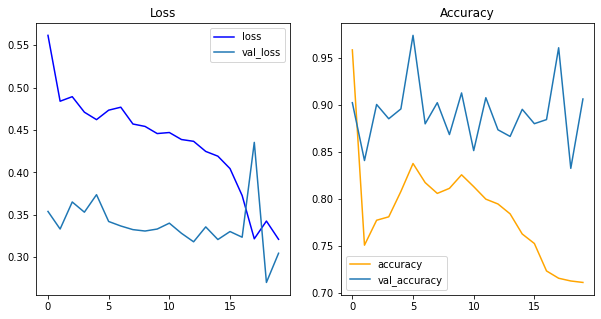

INFO:tensorflow:Assets written to: ram://6f6e0c5b-75b7-437a-a2f0-39a9873817aa/assets


INFO:tensorflow:Assets written to: ram://6f6e0c5b-75b7-437a-a2f0-39a9873817aa/assets


INFO:tensorflow:Assets written to: ram://7856a161-0106-4046-b4d1-e834428c1d5d/assets


INFO:tensorflow:Assets written to: ram://7856a161-0106-4046-b4d1-e834428c1d5d/assets
/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: dataset, example, train_ds, val_ds
  warnings.warn(message)


In [63]:
#!g1.1
if PATH_TO_MODEL['My_Unet']['is_saved']:
  my_unet_model.load_weights(PATH_TO_MODEL['My_Unet']['path'])
else:
  checkpoint = get_checkpoint(PATH_TO_MODEL['My_Unet']['path'])
  history = my_unet_model.fit(train_ds, epochs=20, callbacks=[checkpoint], validation_data=val_ds)
  vis_history(history)

Модель в очередной раз смогла переобучиться, уйдя от лосса в 0.27 на валидации и тренировке к - 0.05 на тренировке и к 0.3 на валидации.  
Обучение проходило на 1600 изображениях(аугментированных), 20 эпох, переобучение началось после 10ой.

#### Проверка результатов работы модели

1/1 [==============================] - 4s 4s/step


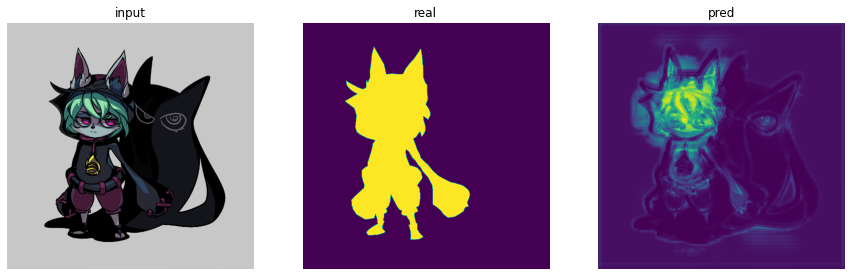

INFO:tensorflow:Assets written to: ram://d8fef554-aa54-42fb-a9e1-80012d416c5b/assets


INFO:tensorflow:Assets written to: ram://d8fef554-aa54-42fb-a9e1-80012d416c5b/assets


INFO:tensorflow:Assets written to: ram://9a14c1e0-e2bd-4274-bce2-2b8fcfe2276a/assets


INFO:tensorflow:Assets written to: ram://9a14c1e0-e2bd-4274-bce2-2b8fcfe2276a/assets


INFO:tensorflow:Assets written to: ram://319b1508-4ff7-4cd6-875c-aae5868bb1e4/assets


INFO:tensorflow:Assets written to: ram://319b1508-4ff7-4cd6-875c-aae5868bb1e4/assets
/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: dataset, example, train_ds, val_ds
  warnings.warn(message)


In [77]:
#!g1.1
get_pred_result(my_unet_model, example)

Результат, хоть и плохой, но весьма забавный хд  

Какое то современное исскуство)

## Та же Unet модель, но со слоями оптимизации
Dropout + BatchNormalisation

In [83]:
#!g1.1
from tensorflow.keras.layers import Dropout, BatchNormalization

INFO:tensorflow:Assets written to: ram://e2b37b7b-af69-4e54-9720-a13f46a6924b/assets


INFO:tensorflow:Assets written to: ram://e2b37b7b-af69-4e54-9720-a13f46a6924b/assets


INFO:tensorflow:Assets written to: ram://5788b3b1-94b7-4ee5-84ee-1804a12395f9/assets


INFO:tensorflow:Assets written to: ram://5788b3b1-94b7-4ee5-84ee-1804a12395f9/assets


In [86]:
#!g1.1
filter_sizes = [64, 128, 256, 512]
bottleneck_kernel_size = 1024

input_layer = Input(shape=(512, 512, 3))

# Encoder
out = input_layer
conv_block_output = []
for filter_size in filter_sizes:
  out = BatchNormalization()(out)
  out = Conv2D(filter_size, 3, activation='relu', padding='same')(out)
  out = Conv2D(filter_size, 3, activation='relu', padding='same')(out)
  conv_block_output.append(out)
  out = MaxPooling2D()(out)
  out = Dropout(0.3)(out)

# bottleneck
out = BatchNormalization()(out)
out = Conv2D(bottleneck_kernel_size, 3, activation='relu', padding='same')(out)
out = Conv2D(bottleneck_kernel_size, 3, activation='relu', padding='same')(out)
out = Dropout(0.3)(out)

# aspp block
enc_out = BatchNormalization()(out)
dil_1 = Conv2D(512, 1, padding='same', activation='relu', name='aspp_1')(enc_out)
dil_8 = Conv2D(512, 1, padding='same', dilation_rate=8, activation='relu', name='aspp_dil_8')(enc_out)
dil_16 = Conv2D(512, 1, padding='same', dilation_rate=16, activation='relu', name='aspp_dil_16')(enc_out)
dil_32 = Conv2D(512, 1, padding='same', dilation_rate=32, activation='relu', name='aspp_dil_32')(enc_out)
dil_concat = Concatenate(axis=3)([dil_1, dil_8, dil_16, dil_32])
dil_out = Conv2D(512, 1, padding='same', activation='relu', name='aspp_out')(dil_concat)

# Decoder
out = dil_out
for filter_size in reversed(filter_sizes):
  out = BatchNormalization()(out)
  out = Conv2DTranspose(filter_size, 3, strides=2, padding='same', activation='relu')(out)
  out = Concatenate(axis=3)([out, conv_block_output.pop(-1)])
  out = Conv2D(filter_size, 3, activation='relu', padding='same')(out)
  out = Conv2D(filter_size, 3, activation='relu', padding='same')(out)
  out = Dropout(0.3)(out)

# output
output = Conv2D(2, 3, padding='same', activation='softmax', name='output')(out)

my_opt_unet_model = Model(inputs=input_layer, outputs=output)
my_opt_unet_model.summary()

2022-09-06 14:47:28.845767: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-06 14:47:33.023847: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-06 14:47:33.704179: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:222] Using CUDA malloc Async allocator for GPU: 0
2022-09-06 14:47:33.705846: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30989 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 3)  12         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['batch_normalization[0][0]']    
                                )                                                             

INFO:tensorflow:Assets written to: ram://ecc7d27d-cd7e-4478-85f3-f8c70ab76923/assets


INFO:tensorflow:Assets written to: ram://ecc7d27d-cd7e-4478-85f3-f8c70ab76923/assets


INFO:tensorflow:Assets written to: ram://eaeda491-be00-49ec-9649-1eda880b1b55/assets


INFO:tensorflow:Assets written to: ram://eaeda491-be00-49ec-9649-1eda880b1b55/assets


In [87]:
#!g1.1
my_opt_unet_model.compile('Adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])

INFO:tensorflow:Assets written to: ram://97ead971-27cf-43a8-8e79-26b07b8b8744/assets


INFO:tensorflow:Assets written to: ram://97ead971-27cf-43a8-8e79-26b07b8b8744/assets


INFO:tensorflow:Assets written to: ram://efb5cc2a-3124-4075-b11c-a16f0dc3d015/assets


INFO:tensorflow:Assets written to: ram://efb5cc2a-3124-4075-b11c-a16f0dc3d015/assets


Epoch 1/20


2022-09-06 14:56:09.128568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-09-06 14:56:09.130932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-09-06 14:56:09.163822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-09-06 14:56:09.165669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-09-06 14:56:11.023824: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8500


387/387 [==============================] - ETA: 0s - loss: 0.3729 - accuracy: 0.9740
Epoch 1: val_loss improved from inf to 0.30192, saving model to saved_models_vex_segm/My_Opt_Unet


INFO:tensorflow:Assets written to: saved_models_vex_segm/My_Opt_Unet/assets


INFO:tensorflow:Assets written to: saved_models_vex_segm/My_Opt_Unet/assets


387/387 [==============================] - 266s 650ms/step - loss: 0.3729 - accuracy: 0.9740 - val_loss: 0.3019 - val_accuracy: 0.9534
Epoch 2/20
387/387 [==============================] - ETA: 0s - loss: 0.3177 - accuracy: 0.8752
Epoch 2: val_loss did not improve from 0.30192
387/387 [==============================] - 234s 604ms/step - loss: 0.3177 - accuracy: 0.8752 - val_loss: 0.4886 - val_accuracy: 0.6301
Epoch 3/20
387/387 [==============================] - ETA: 0s - loss: 0.2299 - accuracy: 0.8346
Epoch 3: val_loss did not improve from 0.30192
387/387 [==============================] - 234s 605ms/step - loss: 0.2299 - accuracy: 0.8346 - val_loss: 0.3149 - val_accuracy: 0.9088
Epoch 4/20
387/387 [==============================] - ETA: 0s - loss: 0.1615 - accuracy: 0.8195
Epoch 4: val_loss improved from 0.30192 to 0.28692, saving model to saved_models_vex_segm/My_Opt_Unet


INFO:tensorflow:Assets written to: saved_models_vex_segm/My_Opt_Unet/assets


INFO:tensorflow:Assets written to: saved_models_vex_segm/My_Opt_Unet/assets


387/387 [==============================] - 245s 633ms/step - loss: 0.1615 - accuracy: 0.8195 - val_loss: 0.2869 - val_accuracy: 0.9188
Epoch 5/20
387/387 [==============================] - ETA: 0s - loss: 0.1181 - accuracy: 0.8130
Epoch 5: val_loss did not improve from 0.28692
387/387 [==============================] - 235s 606ms/step - loss: 0.1181 - accuracy: 0.8130 - val_loss: 0.3689 - val_accuracy: 0.9076
Epoch 6/20
387/387 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.8093
Epoch 6: val_loss did not improve from 0.28692
387/387 [==============================] - 234s 606ms/step - loss: 0.0723 - accuracy: 0.8093 - val_loss: 0.3029 - val_accuracy: 0.8820
Epoch 7/20
387/387 [==============================] - ETA: 0s - loss: 0.0518 - accuracy: 0.8085
Epoch 7: val_loss did not improve from 0.28692
387/387 [==============================] - 234s 605ms/step - loss: 0.0518 - accuracy: 0.8085 - val_loss: 0.3088 - val_accuracy: 0.8639
Epoch 8/20
387/387 [===========

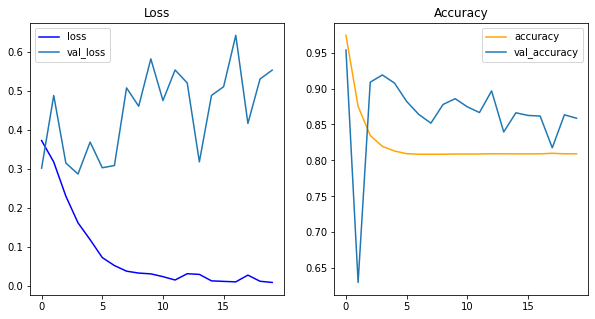

INFO:tensorflow:Assets written to: ram://018fcddb-7cd6-493f-9821-83423e7342c4/assets


INFO:tensorflow:Assets written to: ram://018fcddb-7cd6-493f-9821-83423e7342c4/assets


INFO:tensorflow:Assets written to: ram://f25450fd-2187-46cc-96d8-f564c8e6b3c8/assets


INFO:tensorflow:Assets written to: ram://f25450fd-2187-46cc-96d8-f564c8e6b3c8/assets


INFO:tensorflow:Assets written to: ram://2886357b-1de7-4c52-a006-1288856e9b36/assets


INFO:tensorflow:Assets written to: ram://2886357b-1de7-4c52-a006-1288856e9b36/assets


INFO:tensorflow:Assets written to: ram://abc5c4da-ba0a-415c-a503-401b0c6544ff/assets


INFO:tensorflow:Assets written to: ram://abc5c4da-ba0a-415c-a503-401b0c6544ff/assets
/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: dataset, example, train_ds, val_ds
  warnings.warn(message)


In [92]:
#!g1.1
if PATH_TO_MODEL['My_Opt_Unet']['is_saved']:
  my_opt_unet_model.load_weights(PATH_TO_MODEL['My_Opt_Unet']['path'])
else:
  checkpoint = get_checkpoint(PATH_TO_MODEL['My_Opt_Unet']['path'])
  history = my_opt_unet_model.fit(train_ds, epochs=20, callbacks=[checkpoint], validation_data=val_ds)
  vis_history(history)

1/1 [==============================] - 0s 422ms/step


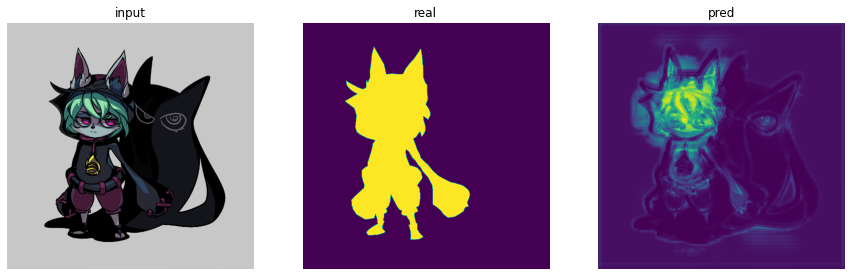

INFO:tensorflow:Assets written to: ram://b4e25060-7c3d-462f-9151-89422c3de7b7/assets


INFO:tensorflow:Assets written to: ram://b4e25060-7c3d-462f-9151-89422c3de7b7/assets


INFO:tensorflow:Assets written to: ram://fdbd8748-d755-4841-a618-37b9ebb938b7/assets


INFO:tensorflow:Assets written to: ram://fdbd8748-d755-4841-a618-37b9ebb938b7/assets


INFO:tensorflow:Assets written to: ram://08301975-6d36-4303-ad90-0cda8a854d4d/assets


INFO:tensorflow:Assets written to: ram://08301975-6d36-4303-ad90-0cda8a854d4d/assets
/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: dataset, example, train_ds, val_ds
  warnings.warn(message)


In [93]:
#!g1.1
get_pred_result(my_unet_model, example)

Модель с BatchNormalisation обучалась сильно быстрее(в 2 раза быстрее о:<), но результат получился примерно такой же как и модели без оптимизации.

Loss получился даже выше на валидации, и сильно ниже на обучении(т.е. модель переобучилась почти сразу).

## Итог
Мои модели пока получились хуже чем реализованные в библиотеке **segmentation_models**.  
Даже с применением методов против переобучения - модель толком не смогла обучиться, зато успешно переобучалась(каждый раз).

Задача, в целом, оказалась не простой для машинного обучения, не решаемой для простых моделей, т.е. для более менее сложных задач - придется использовать точные\сложные реализации с специфическими архитектурами(на подобии того, что реализовано в **segmentation_models**), в которых результат удовлетворителен.

In [ ]:
#!g1.1
